In [ ]:
import pandas as pd
import numpy as np
file_path = "ketapang-12-08-24.csv"
df = pd.read_csv(file_path, sep=";", decimal=",")
df['ID'] = range(1, len(df) + 1)

print(df.head())

           Provinsi  Kab Kota     Kecamatan         Desa     Tanggal  \
0  Kalimantan Barat  KETAPANG  Simpang Hulu  Labai Hilir  12-08-2024   
1  Kalimantan Barat  KETAPANG   Hulu Sungai     Kenyabur  12-08-2024   
2  Kalimantan Barat  KETAPANG   Hulu Sungai      Sekukun  12-08-2024   
3  Kalimantan Barat  KETAPANG   Hulu Sungai   Senduruhan  12-08-2024   
4  Kalimantan Barat  KETAPANG   Hulu Sungai   Senduruhan  12-08-2024   

       Waktu      Satelit Confidence  Latitude  Longitude  ID  
0  09:34 WIB   NASA-MODIS     Medium  -0.61162  109.92787   1  
1  12:40 WIB  NASA-NOAA20     Medium  -0.69322  111.00700   2  
2  12:40 WIB  NASA-NOAA20     Medium  -1.26149  110.77117   3  
3  12:40 WIB  NASA-NOAA20     Medium  -0.96459  110.78564   4  
4  12:40 WIB  NASA-NOAA20     Medium  -0.96401  110.78944   5  


Plot

In [4]:
import folium
map = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=8)

for i, row in df.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=row["ID"]
    ).add_to(map)

map


Distance between location (based on latitude and longitude)

In [5]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

A = (-1.86393, 110.61875)
B = (-1.86332, 110.62273)
C = (-1.86254, 110.6216)

dist_AB = haversine(A[0], A[1], B[0], B[1])
dist_BC = haversine(B[0], B[1], C[0], C[1])
dist_AC = haversine(A[0], A[1], C[0], C[1])

print(f"Distance A to B: {dist_AB:.4f} km")
print(f"Distance B to C: {dist_BC:.4f} km")
print(f"Distance A to C: {dist_AC:.4f} km")

Distance A to B: 0.4475 km
Distance B to C: 0.1526 km
Distance A to C: 0.3524 km


Merge the plot within 300m

In [4]:
from math import radians, sin, cos, sqrt, atan2

# Haversine formula to calculate distance between two lat/lon in meters
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)
    a = sin(dphi/2)**2 + cos(phi1) * cos(phi2) * sin(dlambda/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Convert decimal commas to points and to float
df["Latitude"] = df["Latitude"].astype(str).str.replace(",", ".").astype(float)
df["Longitude"] = df["Longitude"].astype(str).str.replace(",", ".").astype(float)

# Create groups: each cluster of points within 300m
visited = set()
clusters = []
threshold = 300  # meters

for i, row in df.iterrows():
    if i in visited:
        continue
    cluster = [i]
    visited.add(i)
    for j, row2 in df.iterrows():
        if j in visited:
            continue
        dist = haversine(row["Latitude"], row["Longitude"], row2["Latitude"], row2["Longitude"])
        if dist <= threshold:
            cluster.append(j)
            visited.add(j)
    clusters.append(cluster)

# Merge clusters: take mean of lat/lon, keep first metadata
merged = []
for cluster in clusters:
    subset = df.loc[cluster]
    avg_lat = subset["Latitude"].mean()
    avg_lon = subset["Longitude"].mean()
    merged.append({
        "Provinsi": subset.iloc[0]["Provinsi"],
        "Kab Kota": subset.iloc[0]["Kab Kota"],
        "Kecamatan": subset.iloc[0]["Kecamatan"],
        "Desa": ",".join(subset["Desa"].unique()),
        "Tanggal": subset.iloc[0]["Tanggal"],
        "Waktu": subset.iloc[0]["Waktu"],
        "Satelit": ",".join(subset["Satelit"].unique()),
        "Confidence": ",".join(subset["Confidence"].unique()),
        "Latitude": avg_lat,
        "Longitude": avg_lon,
        "Count": len(subset)  # how many merged points
    })

df_merged = pd.DataFrame(merged)
print(df_merged)

            Provinsi  Kab Kota     Kecamatan            Desa     Tanggal  \
0   Kalimantan Barat  KETAPANG  Simpang Hulu     Labai Hilir  12-08-2024   
1   Kalimantan Barat  KETAPANG   Hulu Sungai        Kenyabur  12-08-2024   
2   Kalimantan Barat  KETAPANG   Hulu Sungai         Sekukun  12-08-2024   
3   Kalimantan Barat  KETAPANG   Hulu Sungai      Senduruhan  12-08-2024   
4   Kalimantan Barat  KETAPANG   Hulu Sungai      Senduruhan  12-08-2024   
..               ...       ...           ...             ...         ...   
69  Kalimantan Barat  KETAPANG   Sungai Laur     Merabu Jaya  12-08-2024   
70  Kalimantan Barat  KETAPANG   Sungai Laur  Selangkut Raya  12-08-2024   
71  Kalimantan Barat  KETAPANG   Sungai Laur  Selangkut Raya  12-08-2024   
72  Kalimantan Barat  KETAPANG  Tumbang Titi  Nanga Kelampai  12-08-2024   
73  Kalimantan Barat  KETAPANG  Tumbang Titi   Tanjung Maloi  12-08-2024   

        Waktu      Satelit Confidence  Latitude   Longitude  Count  
0   09:34 WIB   NA

Save the merged into csv

In [ ]:
# df_merged.to_csv("ketapang-12-08-24_merged.csv", index=False)

Plot the merged

In [ ]:
import pandas as pd
import numpy as np
file_path = "ketapang-12-08-24_merged.csv"
df = pd.read_csv(file_path, sep=",", decimal=".")
df['ID'] = range(1, len(df) + 1)

print(df.head())

           Provinsi  Kab Kota     Kecamatan         Desa     Tanggal  \
0  Kalimantan Barat  KETAPANG  Simpang Hulu  Labai Hilir  12-08-2024   
1  Kalimantan Barat  KETAPANG   Hulu Sungai     Kenyabur  12-08-2024   
2  Kalimantan Barat  KETAPANG   Hulu Sungai      Sekukun  12-08-2024   
3  Kalimantan Barat  KETAPANG   Hulu Sungai   Senduruhan  12-08-2024   
4  Kalimantan Barat  KETAPANG   Hulu Sungai   Senduruhan  12-08-2024   

       Waktu      Satelit Confidence  Latitude  Longitude  Count  ID  
0  09:34 WIB   NASA-MODIS     Medium  -0.61162  109.92787      1   1  
1  12:40 WIB  NASA-NOAA20     Medium  -0.69322  111.00700      1   2  
2  12:40 WIB  NASA-NOAA20     Medium  -1.26149  110.77117      1   3  
3  12:40 WIB  NASA-NOAA20     Medium  -0.96459  110.78564      1   4  
4  12:40 WIB  NASA-NOAA20     Medium  -0.96401  110.78944      1   5  


In [3]:
import folium
map = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=8)

for i, row in df.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=row["ID"]
    ).add_to(map)

map


Clustering with KMeans

    Latitude   Longitude  Cluster
0  -0.611620  109.927870        2
1  -0.693220  111.007000        0
2  -1.261490  110.771170        0
3  -0.964590  110.785640        0
4  -0.964010  110.789440        0
..       ...         ...      ...
69 -0.705510  110.601060        2
70 -0.771760  110.600515        2
71 -0.765330  110.599640        2
72 -1.916995  110.472955        1
73 -1.800265  110.674825        1

[74 rows x 3 columns]


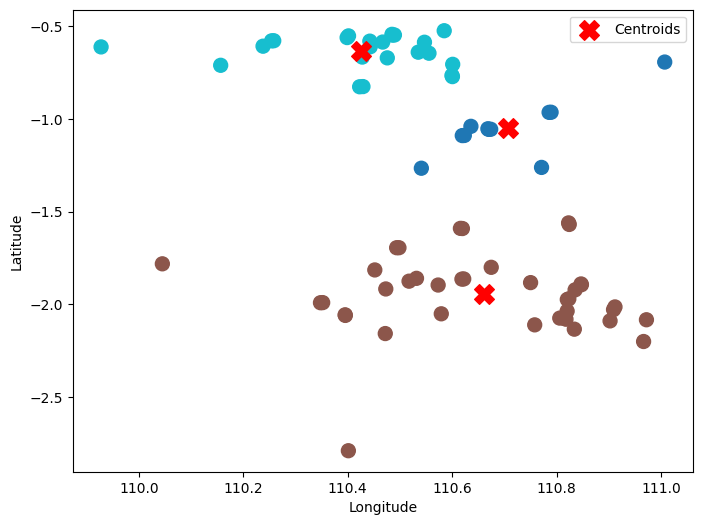

In [11]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select features (latitude & longitude)
X = df[["Latitude", "Longitude"]]

# Apply KMeans clustering with K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X)

# Save results
# df.to_csv("ketapang-12-08-24_merged_clustered_3.csv", index=False)

print(df[["Latitude", "Longitude", "Cluster"]])

# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(df["Longitude"], df["Latitude"], c=df["Cluster"], cmap="tab10", s=100)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], 
            c="red", marker="X", s=200, label="Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


Plotting the cluster

In [12]:
import folium
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors

# Load your clustered data
df = pd.read_csv("ketapang-12-08-24_merged_clustered_3.csv")

# Create base map
m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=8)

# Generate distinct colors for each cluster
num_clusters = df["Cluster"].nunique()
colormap = cm.get_cmap("tab10", num_clusters)  # can use 'tab20', 'Set1', etc.
norm = colors.Normalize(vmin=0, vmax=num_clusters-1)

cluster_colors = {
    cluster: colors.to_hex(colormap(norm(cluster)))
    for cluster in df["Cluster"].unique()
}

# Add markers by cluster
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=6,
        popup=(
            f"ID: {row['ID']}<br>"
            f"Cluster: {row['Cluster']}<br>"
            f"Desa: {row['Desa']}<br>"
            f"Kecamatan: {row['Kecamatan']}<br>"
            f"Satelit: {row['Satelit']}"
        ),
        color=cluster_colors[row["Cluster"]],
        fill=True,
        fill_color=cluster_colors[row["Cluster"]],
        fill_opacity=0.8
    ).add_to(m)

m


C:\Users\mrifq\AppData\Local\Temp\ipykernel_16984\2388479402.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("tab10", num_clusters)  # can use 'tab20', 'Set1', etc.
